In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, glob
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist
from scipy.stats import beta as Beta


models

In [2]:
def gauss(params, normed_stim):
    '''gauss noise'''
    sigma = params[0]
    mu = normed_stim
    return mu, np.full_like(normed_stim, sigma)

def gauss_bias(params, normed_stim):
    '''gauss noise + bias'''
    sigma, bias = params
    mu = normed_stim + bias
    return mu, np.full_like(normed_stim, sigma)

def beta_const_noise(params, normed_stim, EPS=1e-9):
    """const noise, kappa"""
    (kappa,) = params
    mu = np.clip(normed_stim.astype(float), EPS, 1-EPS) # guards endpoints
    a  = mu * kappa
    b  = (1 - mu) * kappa
    return a, b

def beta_var_noise(params, normed_stim, EPS=1e-9):
    ''' stim-dependent noise (kappa)'''
    eta0, eta1 = params
    mu = np.clip(normed_stim.astype(float), EPS, 1-EPS)          # clip μ

    # kappa varies with distance from boundary (-.5 bc normed)
    kappa = softplus(eta0 + eta1 * np.abs(mu - 0.5)) + 1e-6 # κ>0
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def beta_logistic_mu(params, normed_stim, EPS=1e-9):
    ''' logistic mean, const kappa '''

    assert np.all((0 <= normed_stim) & (normed_stim <= 1)), "stim must be in [0,1]"
    # bias, slope, noise param for mu
    w0, w1, eta = params

    # logistic
    mu = 1.0 / (1.0 + np.exp(-(w0 + w1*(normed_stim - 0.5))))
    mu = np.clip(mu.astype(float), EPS, 1-EPS)
    
    # const kappa
    kappa = softplus(eta) + 1e-6
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def norm01(x, lo=-.38, hi=.38):
    '''Normalize input to [0,1] range.'''
    normed = (x - lo) / (hi - lo)
    clipped = np.clip(normed, 1e-6, 1-1e-6)
    return clipped

def inv_norm01(y, lo=-.38, hi=.38):
    """Map [0,1] back to [lo,hi]."""
    return lo + y * (hi - lo)

def softplus(z): return np.log1p(np.exp(z))


fitting & comparing functions

In [3]:
def gauss_ll(gauss_model, params, normed_stim, normed_resp):
    '''Log-likelihood for Gaussian continuous responses.'''
    mu, sigma = gauss_model(params, normed_stim)
    resid = normed_resp - mu

    ll = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (resid**2)/(sigma**2))
    return ll

def beta_ll(beta_model, params, normed_stim, normed_resp, EPS=1e-9):
    '''Log-likelihood for Beta continuous responses.'''
    a, b = beta_model(params, normed_stim)
    normed_resp = np.clip(normed_resp.astype(float), EPS, 1 - EPS)  # guard endpoints
    ll = np.sum(beta_dist.logpdf(normed_resp, a=a, b=b))
    return ll

def fit_model(model, stim, resp, init_params, bounds):
    '''Fit a model to the data by minimizing the negative log-likelihood.'''

    # choose the right likelihood function
    ll_func = beta_ll if model in beta_models else gauss_ll

    # wrapper: given parameters, compute *negative* log-likelihood
    def nll(theta):
        loglik = ll_func(model, theta, norm01(stim), norm01(resp))
        return -loglik
    
    result = minimize(nll, init_params, bounds=bounds)
    return result.x, -result.fun # params, -ll

def bic(loglik, num_params, num_trials):
    '''Bayesian Information Criterion (BIC) for model comparison.'''
    return -2*loglik + num_params * np.log(num_trials)


data

In [4]:
# REAL
df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_baseline = df[df['condition']=='baseline'].copy()
stims = df['stim_pos_aligned'].values
resps = df['chosen_pos_aligned'].values
div = df['div_pos_aligned'].values[0]


fitting data

In [5]:
# model families
beta_models = {beta_const_noise, beta_var_noise, beta_logistic_mu}
gauss_models = {gauss, gauss_bias}

# models to run
models_info = [
    (gauss,             [0.5],              [(1e-6, None)]),                     # sigma
    # (beta_const_noise,  [5.0],              [(1e-6, None)]),                     # kappa (const noise)
    (beta_var_noise,    [1.0, 0.0],         [(None, None), (None, None)]),       # eta0, eta1 (base noise, stim-dependent noise)
    (beta_logistic_mu,     [0.0, 3.0, 1.0],    [(None,None),(None,None),(None,None)]) # w0, w1, eta (bias, slope, const noise)
]

# storing recovered metrics
model_metrics = {}
for model, init, bounds in models_info:
    params, ll = fit_model(model, stims, resps, init_params=init, bounds=bounds)
    model_metrics[model] = {'params': params, 'LL': ll, 'BIC': bic(ll, len(params), len(stims))}

# print
for model, metrics in model_metrics.items():
    print(model.__name__)
    for metric, val in metrics.items():
        print(metric, val)
    print()


gauss
params [0.20989787]
LL 204.76171519627692
BIC -402.2510319999838

beta_var_noise
params [1.209094   6.88025472]
LL -1329.8215551352846
BIC 2674.1879070557093

beta_logistic_mu
params [-0.04532754  2.93414477  2.37503349]
LL 448.9263781283288
BIC -876.0355610789475



## checks

scatters

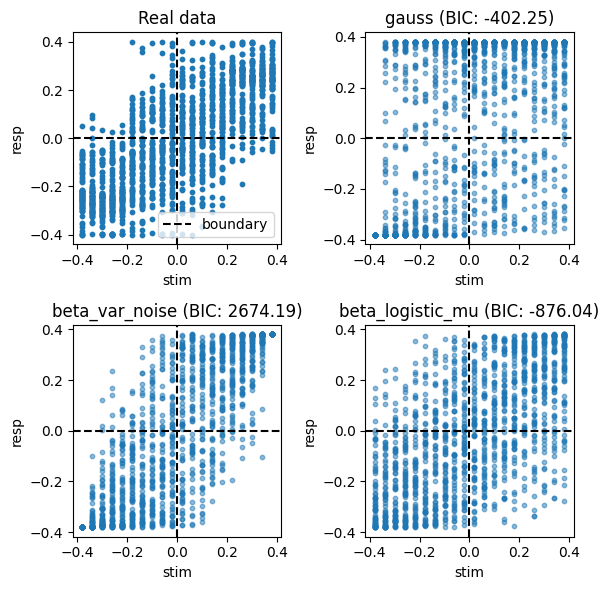

In [6]:
n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0

# real data
axs[ax].scatter(stims, resps, s=10)
axs[ax].axvline(div, color='k', linestyle='--', label='boundary')
axs[ax].axhline(div, color='k', linestyle='--')
axs[ax].set(title='Real data', xlabel='stim', ylabel='resp')
axs[ax].legend()
ax += 1

# simulated data
for model in model_metrics:
    
    # recover
    fit_params = model_metrics[model]['params']
    BIC = model_metrics[model]['BIC']
    
    a, b = model(fit_params, norm01(stims)) # pass normed stim
    sim_resp = inv_norm01(np.random.beta(a, b)) # recover unnormed resp
    axs[ax].scatter(stims, sim_resp, s=10, alpha=.5)
    axs[ax].axvline(div, color='k', linestyle='--')
    axs[ax].axhline(div, color='k', linestyle='--')
    axs[ax].set(title=f'{model.__name__} (BIC: {BIC:.2f})', xlabel='stim', ylabel='resp')
    ax += 1

plt.tight_layout()
plt.show()

response distributions & PDFs - sid, just align x axis to 0-1

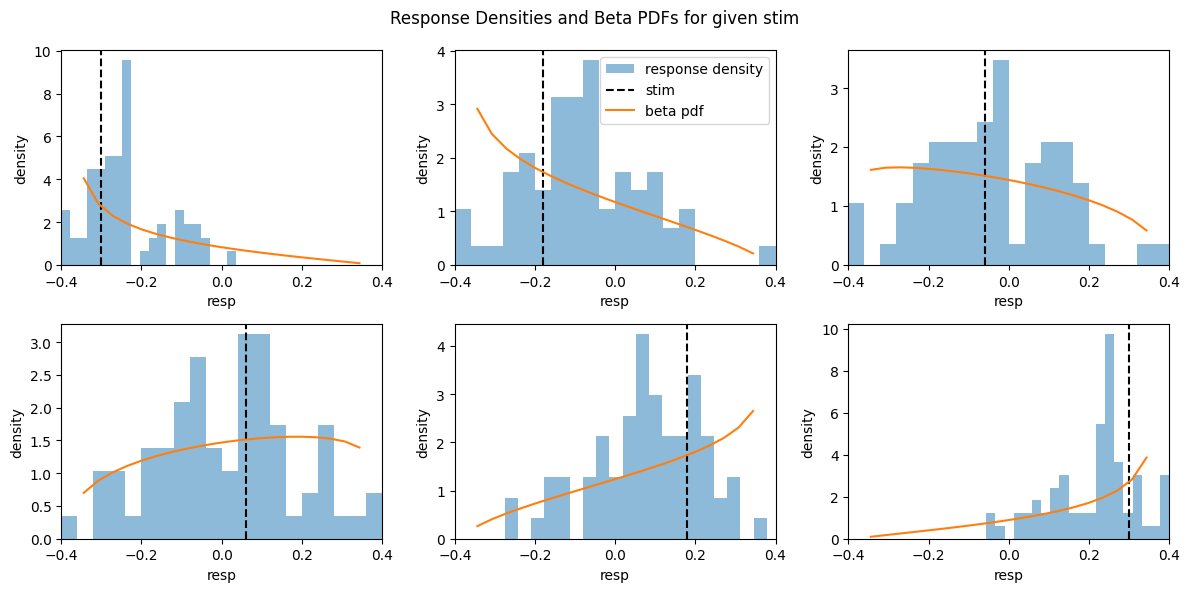

In [7]:
# choose 6 equidistant stim_pos between index 2 and -3 (incl)
unique_sorted_stim = np.sort(df['stim_pos_aligned'].unique())
rand_stims = np.linspace(2, len(unique_sorted_stim)-3, 6, dtype=int)
rand_stims = unique_sorted_stim[rand_stims]

# fitted params and corresponding beta params
logistic_params = model_metrics[beta_logistic_mu]['params']

fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*3))
axs, ax = axs.flatten(), 0
for rand_stim in rand_stims:
    
    # hist of responses
    rand_resps = df[df['stim_pos_aligned'] == rand_stim]['chosen_pos_aligned'].values
    axs[ax].hist(rand_resps, bins=20, density=True, alpha=.5, label = 'response density')
    axs[ax].axvline(rand_stim, color='k', linestyle='--', label='stim')
    axs[ax].set(xlabel='resp', ylabel='density', xlim=(-.4, .4))
    
    # beta pdf
    normed_resp = np.linspace(0, 1, 22)[1:-1]
    a, b = beta_logistic_mu(logistic_params, np.array([norm01(rand_stim)]))
    # divide by diff to ensure curve integrates to 1, not diff (where diff = 0.38 - (-0.38))
    axs[ax].plot(inv_norm01(normed_resp), Beta(a, b).pdf(normed_resp) / (0.38 - (-0.38)), label='beta pdf')
    
    ax += 1

axs[1].legend()
plt.suptitle('Response Densities and Beta PDFs for given stim')
plt.tight_layout()
plt.show()


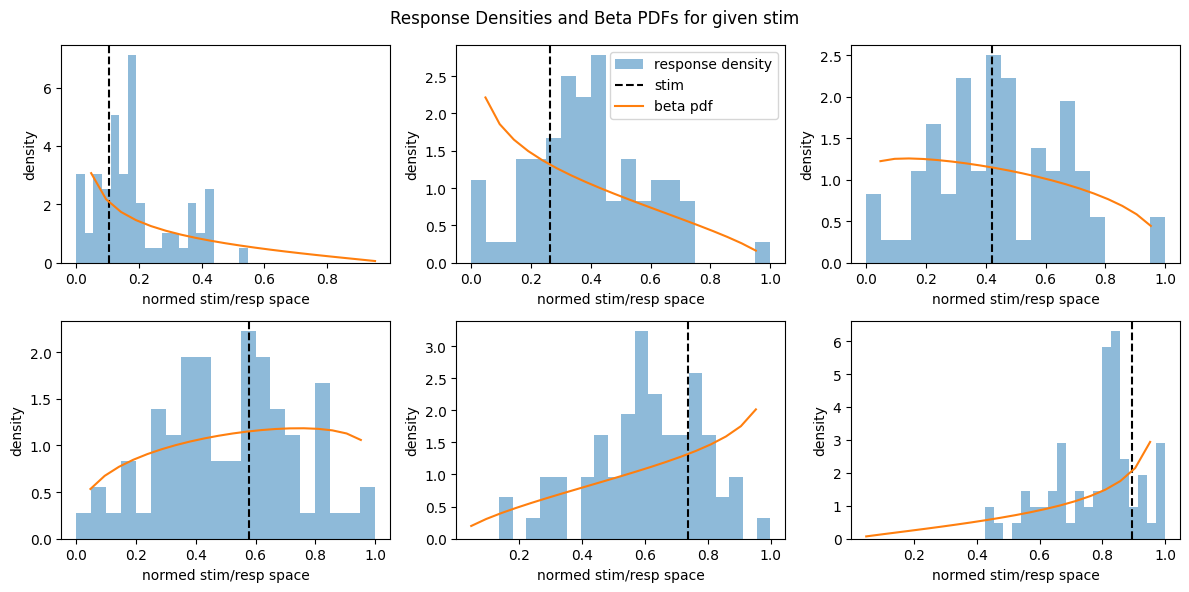

In [11]:
# choose 6 equidistant stim_pos between index 2 and -3 (incl)
unique_sorted_stim = np.sort(df['stim_pos_aligned'].unique())
rand_stims = np.linspace(2, len(unique_sorted_stim)-3, 6, dtype=int)
rand_stims = unique_sorted_stim[rand_stims]

# fitted params and corresponding beta params
logistic_params = model_metrics[beta_logistic_mu]['params']

fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*3))
axs, ax = axs.flatten(), 0
for rand_stim in rand_stims:
    
    # hist of responses
    rand_resps = df[df['stim_pos_aligned'] == rand_stim]['chosen_pos_aligned'].values
    axs[ax].hist(norm01(rand_resps), bins=20, density=True, alpha=.5, label = 'response density')
    axs[ax].axvline(norm01(rand_stim), color='k', linestyle='--', label='stim')
    axs[ax].set(xlabel='normed stim/resp space', ylabel='density')
    
    # beta pdf
    a, b = beta_logistic_mu(logistic_params, np.array([norm01(rand_stim)]))
    x01 = np.linspace(0, 1, 22)[1:-1]
    axs[ax].plot(x01, Beta(a, b).pdf(x01), label='beta pdf')

    ax += 1

axs[1].legend()
plt.suptitle('Response Densities and Beta PDFs for given stim')
plt.tight_layout()
plt.show()


posterior predictive checks

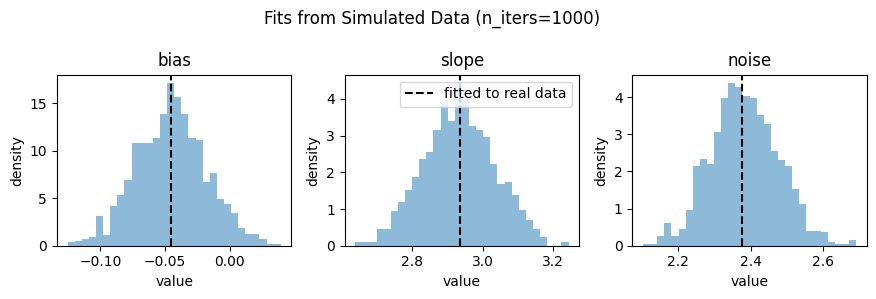

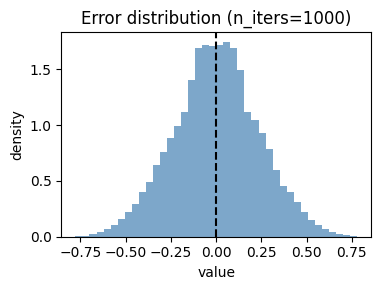

In [ ]:
# map to append simulated fitted Hparams
Hparam_map = {'bias': [], 'slope': [], 'noise': []}

errs = []

# beta params
a, b = model(logistic_params, norm01(stims))

n_iters = 1000
for i in range(n_iters):

    sim_resp = inv_norm01(np.random.beta(a, b))
    errs.append(resps - sim_resp)

    # recover Hparam for each simulated response
    Hparams, nLL = fit_model(beta_logistic_mu, stims, sim_resp, init_params=[0.0, 3.0, 1.0], bounds=[(None,None),(None,None),(None,None)])
    Hparam_map['bias'].append(Hparams[0])
    Hparam_map['slope'].append(Hparams[1])
    Hparam_map['noise'].append(Hparams[2])

errs = np.array(errs)

# plot 1
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
axs, ax = axs.flatten(), 0

for Hparam_name in Hparam_map.keys():

    axs[ax].hist([Hparam_map[Hparam_name]], bins=30, density=True, alpha=0.5)
    axs[ax].axvline(logistic_params[ax], color='k', linestyle='--', label='fitted to real data')
    axs[ax].set(xlabel='value', ylabel='density', title=Hparam_name)
    ax += 1

axs[0].locator_params(axis='x', nbins=6)  # fewer ticks
axs[1].legend()
plt.suptitle(f'Fits from Simulated Data (n_iters={n_iters})')
plt.tight_layout()
plt.show()

# plot 2
plt.figure(figsize=(4,3))
plt.hist(errs.flatten(), bins=40, density=True, alpha=0.7, color='steelblue')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('value')
plt.ylabel('density')
plt.title(f'Error distribution (n_iters={n_iters})')

plt.tight_layout()
plt.show()
